In [1]:
import numpy as np
import struct
import matplotlib.pyplot as plt
import torch
import torch.nn as nn

In [2]:
nums_photo = 2

def read_sonar_data(file_path):
    # Read sonar beam data from a .dat file and return a matrix of image data
    valid_ping_num = nums_photo  # Number of valid pings
    num_IMG = 307200  # Total image data points per ping

    img_8bit_matrix = np.zeros((num_IMG, valid_ping_num), dtype=np.uint8)  # Initialize the output matrix

    with open(file_path, 'rb') as file:
        file.read(40)  # Read and discard the file header (10 uint32)

        # Fixed header search
        c1 = struct.unpack('B', file.read(1))[0]
        c2 = struct.unpack('B', file.read(1))[0]
        c3 = struct.unpack('B', file.read(1))[0]
        for k in range(valid_ping_num):
            if file.read(0) == 'b':
                break
            # Header search within 64k
            for kk in range(65535):
                c4 = struct.unpack('B', file.read(1))[0]
                if c4 == ord('O') and c3 == ord('S') and c2 == 0 and c1 == 0:
                    break
                c1, c2, c3 = c2, c3, c4

                if file.read(0) == 'b':
                    return img_8bit_matrix

            if kk == 65535:
                return img_8bit_matrix
            file.read(14)  # Read and discard SHeaderStr

            mode = np.frombuffer(file.read(5), dtype=np.uint8)
            range_percent = struct.unpack('d', file.read(8))[0]
            gain_percent = struct.unpack('d', file.read(8))[0]
            speed_of_sound = struct.unpack('d', file.read(8))[0]
            salinity = struct.unpack('d', file.read(8))[0]
            ext_flags = struct.unpack('I', file.read(4))[0]
            reserved = np.frombuffer(file.read(32), dtype=np.uint32)

            num_dat16 = reserved[4]  # Sample points
            chn_dat16 = reserved[5]  # Channels

            ping_id = struct.unpack('I', file.read(4))[0]
            status = np.frombuffer(file.read(69), dtype=np.uint8)
            range_resolution = struct.unpack('d', file.read(8))[0]
            n_ranges = struct.unpack('H', file.read(2))[0]
            n_beams = struct.unpack('H', file.read(2))[0]
            file.read(28)  # Read and discard spare

            # Update sample points and beams
            num_sam = n_ranges
            num_beam = float(n_beams)

            file.read(1024)  # Read and discard beam angles (512 int16)
            file.read(822)  # Read and discard tem16 (411 uint16)

            # Read image data
            img_8bit = np.frombuffer(file.read(num_IMG), dtype=np.uint8)
            img_8bit_matrix[:, k] = img_8bit

    return img_8bit_matrix


def reshape_img_matrix(img_8bit_matrix):
    # Ensure img_8bit_matrix has the shape (307200, 500)
    if img_8bit_matrix.shape != (307200, nums_photo):
        raise ValueError("img_8bit_matrix must have shape (307200, 500)")

    # Reshape each column into a (600, 512) array
    reshaped_arrays = np.empty((600, 512, img_8bit_matrix.shape[1]), dtype=np.uint8)

    for k in range(img_8bit_matrix.shape[1]):
        reshaped_arrays[:, :, k] = img_8bit_matrix[:, k].reshape((600, 512))

    return reshaped_arrays

In [3]:
# 一层并行
import torch
import torch.nn as nn

# 卷积神经网络模型
class ConvNet(nn.Module):
    def __init__(self):
        super(ConvNet, self).__init__()
        # 编码器部分
        self.encoder1 = nn.Sequential(
            nn.Conv2d(1, 32, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),
            nn.Conv2d(32, 128, kernel_size=5, stride=1, padding=2),
            nn.ReLU(),
            nn.MaxPool2d(2, 2)
        )

        self.encoder2 = nn.Sequential(
            nn.Conv2d(1, 32, kernel_size=15, stride=1, padding=7),  # 使用不同的卷积核大小
            nn.ReLU(),
            nn.MaxPool2d(2, 2),
            nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1),  # 使用不同的卷积核大小
            nn.ReLU(),
            nn.MaxPool2d(2, 2)
        )

        # self.encoder3 = nn.Sequential(
        #     nn.Conv2d(64, 64, kernel_size=3, stride=1, padding=1),
        #     nn.ReLU(),
        #     nn.MaxPool2d(2, 2)
        # )

        # 解码器部分
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(192, 64, kernel_size=2, stride=2),
            nn.ReLU(),
            # nn.ConvTranspose2d(32, 16, kernel_size=2, stride=2),
            # nn.ReLU(),
            nn.ConvTranspose2d(64, 1, kernel_size=2, stride=2),
            nn.Sigmoid()
        )

    def forward(self, x):
        # 并行编码
        encoded1 = self.encoder1(x)
        encoded2 = self.encoder2(x)

        # 将两个编码器的输出拼接在一起
        encoded = torch.cat((encoded1, encoded2), dim=1)  # 在通道维度拼接

        # 继续编码
        # encoded = self.encoder3(encoded)

        # 解码过程
        decoded = self.decoder(encoded)
        return decoded



# 2. 加载训练好的模型
def load_trained_model(model_path):
    # 定义模型架构
    model = ConvNet()

    # 加载训练好的权重
    model.load_state_dict(torch.load(model_path))

    # 切换到评估模式
    model.eval()

    return model


# 3. 预处理新数据
def preprocess_new_data(new_sonar_data):
    # 对新数据进行预处理，确保形状和输入的训练数据一致
    new_data = np.moveaxis(new_sonar_data, -1, 0)  # 调整轴顺序
    new_data = np.expand_dims(new_data, axis=1)  # 扩展通道维度
    new_data = (new_data - np.min(new_data)) / (np.max(new_data) - np.min(new_data))  # 归一化
    new_data_tensor = torch.tensor(new_data, dtype=torch.float32)
    return new_data_tensor


# 4. 使用模型进行推断
def detect_anomalies(model, data_tensor):
    with torch.no_grad():  # 禁用梯度计算以加快推断速度
        predictions = model(data_tensor)
    return predictions


# 5. 可视化原始数据与异常点
def plot_anomalies(original_data, predictions, slice_idx):
    original_img = original_data[slice_idx, 0, :, :].cpu().numpy()  # 获取原始数据
    prediction_mask = predictions[slice_idx, 0, :, :].cpu().numpy()  # 获取模型预测的异常点

    plt.figure(figsize=(10, 5))

    # 显示原始图像
    plt.subplot(1, 2, 1)
    plt.imshow(original_img, cmap='gray')
    plt.title(f"Original Image (Slice {slice_idx})")
    plt.colorbar()

    # 显示预测的异常点
    plt.subplot(1, 2, 2)
    plt.imshow(original_img, cmap='gray')  # 灰度图作为背景
    plt.imshow(prediction_mask, cmap='Reds', alpha=0.5)  # 红色的异常点叠加显示
    plt.title(f"Predicted Anomalies (Slice {slice_idx})")
    plt.colorbar()

    plt.show()


# 6. 综合步骤：加载模型、处理新数据、进行预测并可视化
def run_anomaly_detection(model_path, new_sonar_data):
    # 加载训练好的模型
    model = load_trained_model(model_path)

    # 预处理新数据
    data_tensor = preprocess_new_data(new_sonar_data)

    # 使用模型进行推断，检测异常点
    predictions = detect_anomalies(model, data_tensor)

    # 可视化异常点
    for slice_idx in range(data_tensor.shape[0]):
        plot_anomalies(data_tensor, predictions, slice_idx)

In [4]:
# 假设有新的声呐数据（替换为实际的数据文件路径）
file_path = "./data/go22-26m.dat"

# 读取并处理声呐数据
img_8bit_matrix = read_sonar_data(file_path)
new_sonar_data = reshape_img_matrix(img_8bit_matrix)  # 重新调整数据形状

# 模型文件路径
trained_model_path = './model/smallmodeland.pth'

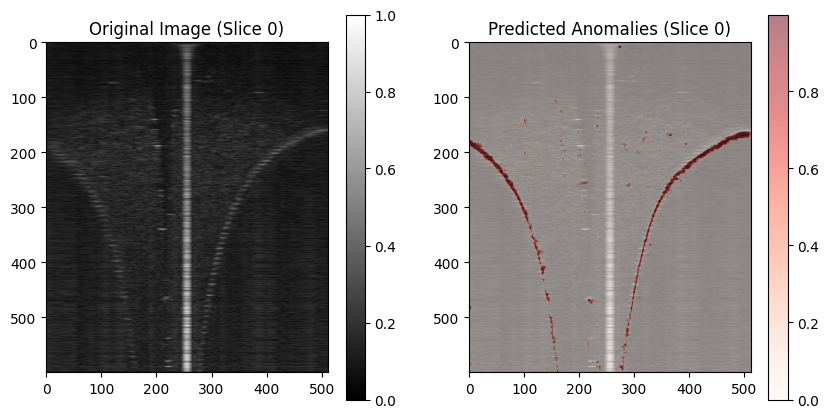

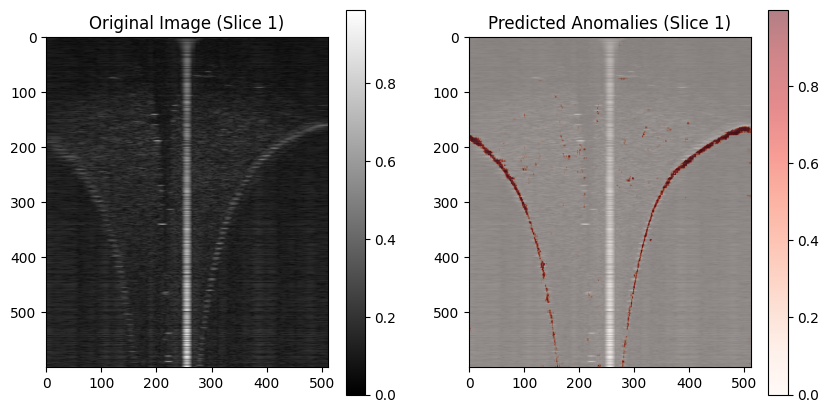

In [8]:
# 运行异常点检测
run_anomaly_detection(trained_model_path, new_sonar_data)